# Quick-look Production Performance Metrics Using Public Data

## Import many of the necessary modules to perform data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Generate DataFrame of CSV data.  In this case we are using Eagle Ford horizontal well data and 6-month cummulative production (2-phase)

In [2]:
sixmnth = pd.read_csv('XXXXX') #Insert directory for dataset

In [3]:
sixmnth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4101 entries, 0 to 4100
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   API14     4101 non-null   int64  
 1   INTERVAL  4101 non-null   object 
 2   TVD       4101 non-null   int64  
 3   LL        4101 non-null   int64  
 4   PROP_FT   4101 non-null   int64  
 5   FLD_FT    4101 non-null   int64  
 6   LBS_BBL   4101 non-null   int64  
 7   SOAK      4101 non-null   int64  
 8   GOR       4101 non-null   int64  
 9   LAT       4101 non-null   float64
 10  LONG      4101 non-null   float64
 11  MBOE      4101 non-null   int64  
 12  OIL_API   4101 non-null   int64  
dtypes: float64(2), int64(10), object(1)
memory usage: 416.6+ KB


> All of the data we will need for the evaluation is numeric with the exception of Interval which designates if a horizontal targted the Upper or Lower Eagle Ford.  We will have to create a dummy variable for this attribute later

### Some data exploration to look for trends and outliers.  In this workflow, the target variable will be 6-month cummulative production in MBOE

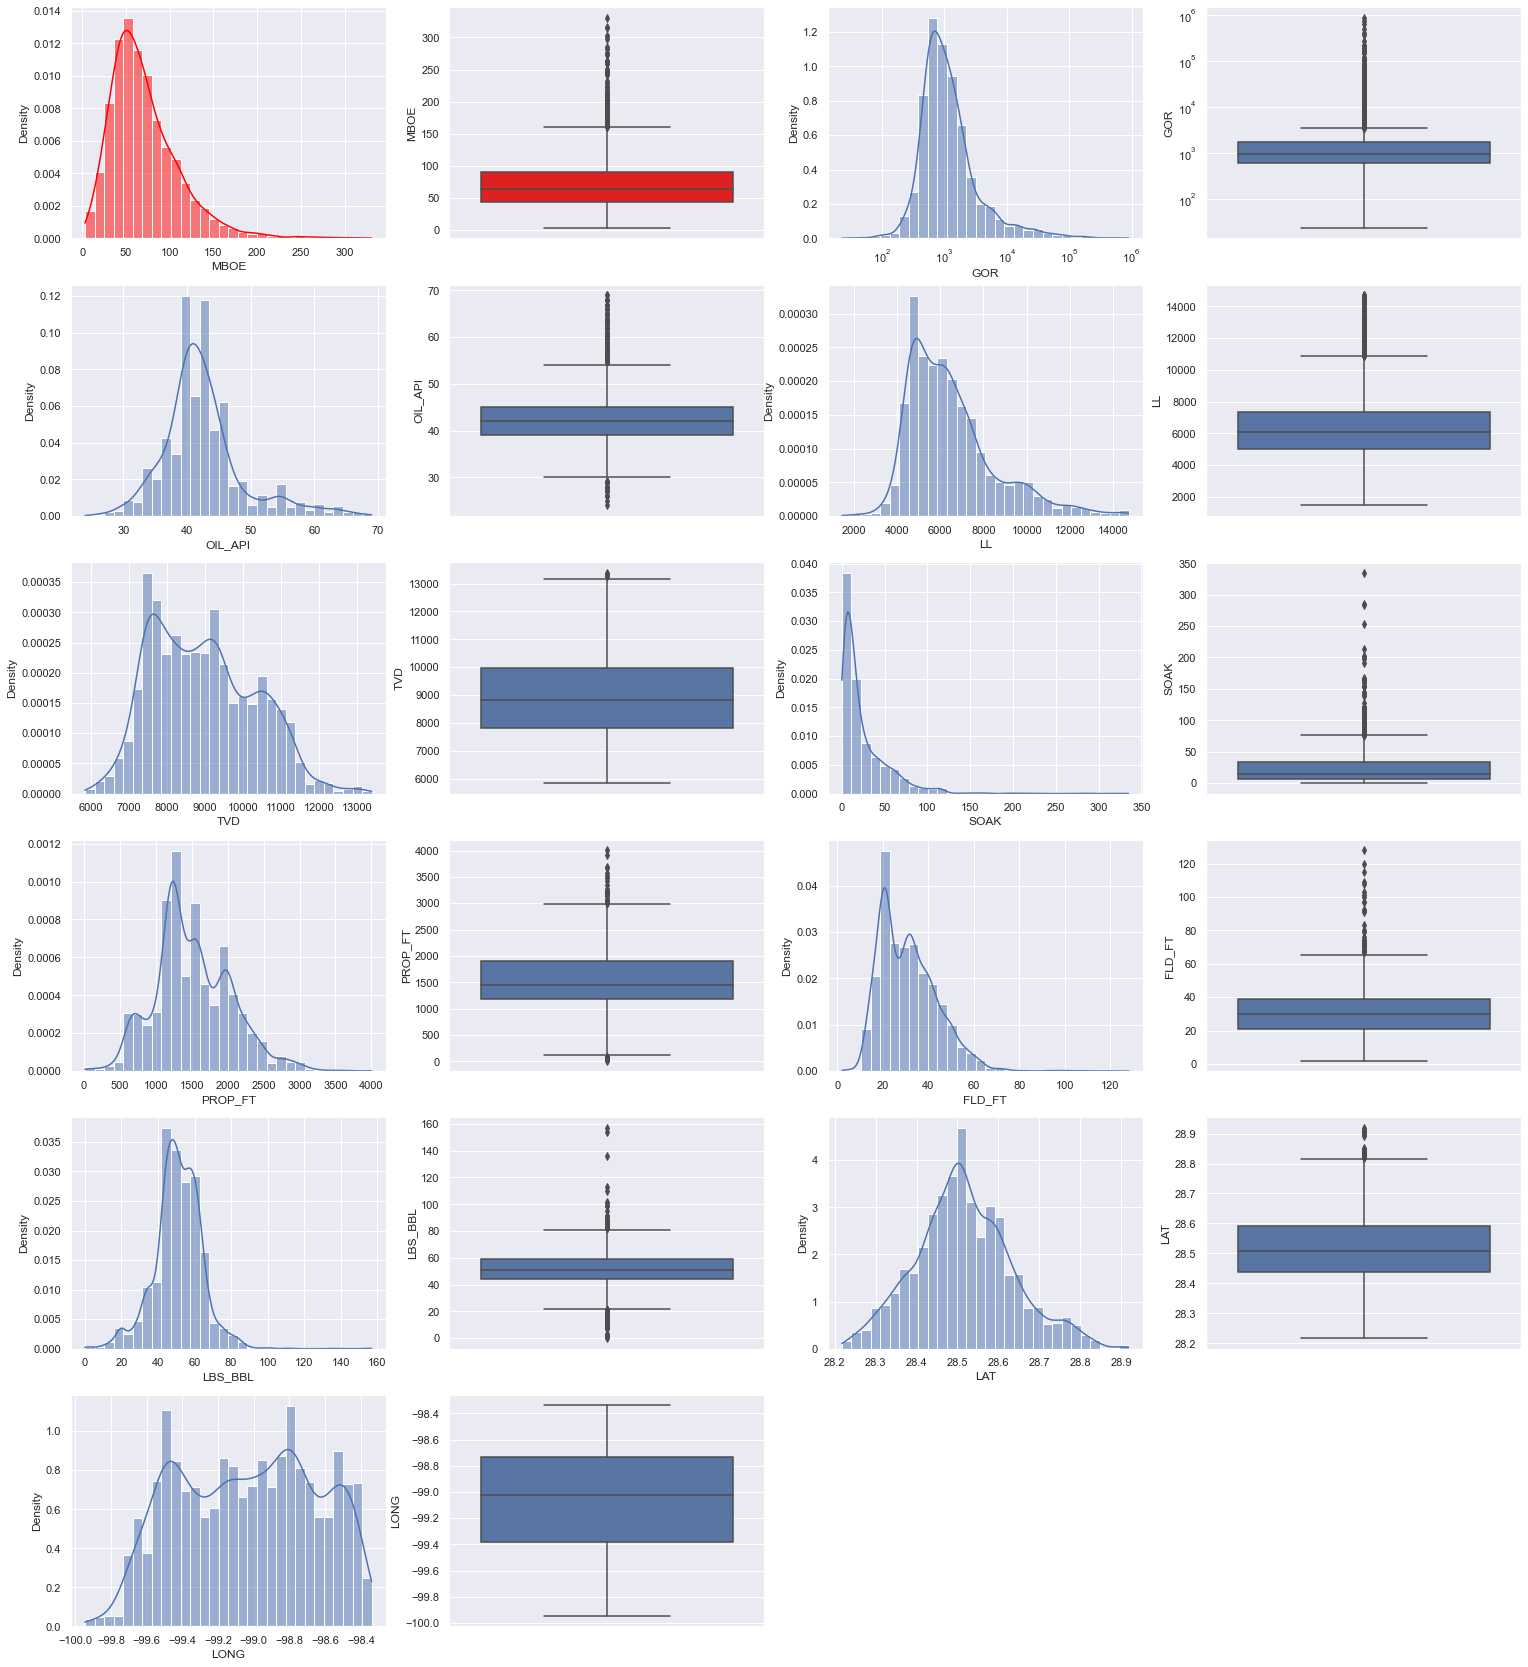

In [4]:
sns.set(font_scale = 1)
plt.figure(figsize=(26,40))

count = 1
attributes = ['MBOE', 'GOR', 'OIL_API', 'LL', 'TVD', 'SOAK', 'PROP_FT', 'FLD_FT', 'LBS_BBL', 'LAT', 'LONG']

for i in attributes:
    plt.subplot(8,4,count)
    if count in range(1,3):
        sns.histplot(data = sixmnth, x = i, bins = 30, kde = True, stat = 'density', color = 'red')
    elif count == 3:
        sns.histplot(data = sixmnth, x = i, bins = 30, kde = True, stat = 'density', log_scale=True)
    else:
        sns.histplot(data = sixmnth, x = i, bins = 30, kde = True, stat = 'density')
    count += 1

    plt.subplot(8,4,count)
    if count in range(1,3):
        sns.boxplot(data = sixmnth, y = i, color = 'red')
    elif count == 4:
        box = sns.boxplot(data = sixmnth, y = i)
        box.set(yscale = 'log')
    else:
        sns.boxplot(data = sixmnth, y = i)
    count += 1   
    
plt.show()

> Some feature and target outliers are observed which could be due to poor data (it is publicly sourced after all) or well location.  Because this is a quick-look workflow and because we can't confirm the cause, we will keep them in the dataset

### Let's generate our dummy dataset for the target interval

In [5]:
sixmnth['EGFD_UP'] = pd.get_dummies(sixmnth['INTERVAL'],drop_first=True)
sixmnth.drop(['INTERVAL'], axis = 1, inplace=True)
sixmnth.head()

,API14,TVD,LL,PROP_FT,FLD_FT,LBS_BBL,SOAK,GOR,LAT,LONG,MBOE,OIL_API,EGFD_UP
0,42311357870000,12633,6022,1309,21,63,7,40597,28.3687,-98.5030,111,54,0
1,42311346650000,12113,5076,1071,19,55,12,6184,28.3718,-98.5191,94,54,0
2,42311358540000,11468,3150,3000,56,53,1,1771,28.4590,-98.5124,30,45,1
3,42311347510000,11140,4776,1179,19,63,164,2684,28.4216,-98.6268,33,48,0
4,42311350830000,10377,6133,1245,23,55,43,1305,28.5944,-98.4672,52,45,0


### Now that our dataset is ready, let's look for collinearity using a heatmap and Pearson Coefficients.  Drop API14 as that is the well identifier

<AxesSubplot:>

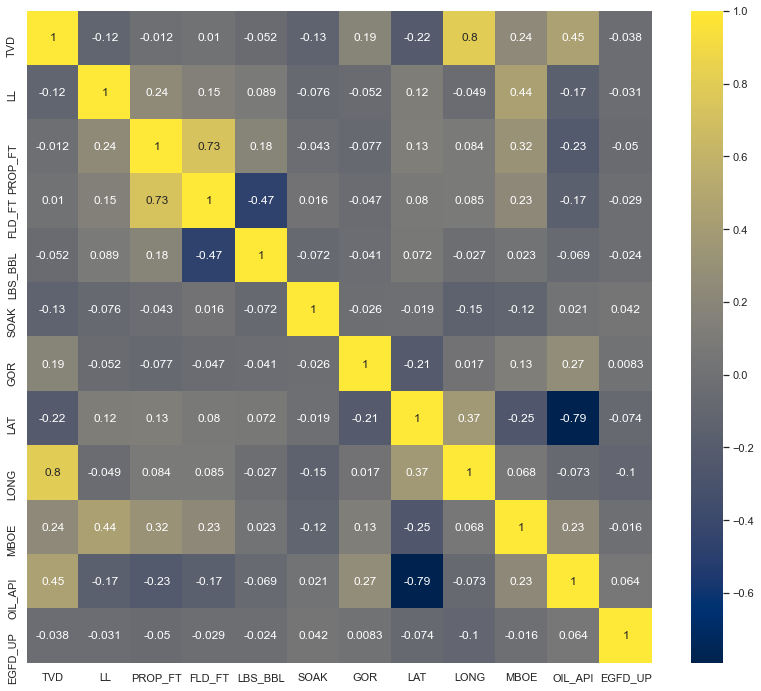

In [6]:
plt.figure(figsize = (14,12))
sns.heatmap(sixmnth.drop(['API14'],axis = 1).corr(), annot = True, cmap = 'cividis')

> There are a few features that appear to be corelative to others which means they could be dropped from the evaluation.  Having a little knowledge of the area/basin will help determine when to drop and when to keep features.  Fot this initial run, I will drop FLD_FT and LONG (SHL Longitude)

In [7]:
sixmnth.drop(['API14','LONG','FLD_FT'], inplace=True, axis = 1)

### Because we will be utilizing a linear regression function as part of our review, we will need to standardize the dataset to ensure that moel results are not influenced by feature scale

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sixmnth_n = scaler.fit_transform(sixmnth)
sixmnth_n = pd.DataFrame(sixmnth_n)
sixmnth_n.columns = sixmnth.columns
sixmnth_n.describe()

,TVD,LL,PROP_FT,LBS_BBL,SOAK,GOR,LAT,MBOE,OIL_API,EGFD_UP
count,4.101000e+03,4.101000e+03,4.101000e+03,4.101000e+03,4.101000e+03,4.101000e+03,4.101000e+03,4.101000e+03,4.101000e+03,4.101000e+03
mean,-3.800639e-16,1.656536e-16,-1.526151e-16,-9.628159e-17,1.061223e-16,-1.649024e-17,-2.373389e-15,6.529091e-17,-3.836076e-15,9.193654e-17
std,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00
min,-2.290781e+00,-2.494569e+00,-2.801156e+00,-3.883247e+00,-8.818861e-01,-1.542830e-01,-2.508808e+00,-1.693449e+00,-2.864777e+00,-3.163126e-01
25%,-8.411604e-01,-7.490820e-01,-6.075387e-01,-5.300286e-01,-6.644064e-01,-1.328642e-01,-6.564051e-01,-6.978237e-01,-5.342594e-01,-3.163126e-01
50%,-9.568342e-02,-1.954539e-01,-1.146749e-01,3.437883e-03,-3.744335e-01,-1.195098e-01,-5.966909e-02,-2.000112e-01,-6.815576e-02,-3.163126e-01
75%,7.538651e-01,4.150707e-01,7.366354e-01,6.131139e-01,3.504989e-01,-8.987868e-02,6.261571e-01,4.720358e-01,3.979478e-01,-3.163126e-01
max,3.275201e+00,4.062386e+00,4.649676e+00,8.081645e+00,1.126073e+01,3.294327e+01,3.386271e+00,6.470677e+00,4.126777e+00,3.161430e+00


### Now let's create our training and test dataset and then run the models through several different regressors using scikit-learn.  FIrst, import the train-test-split module

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = sixmnth.drop(['MBOE'], axis = 1)
y = sixmnth['MBOE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
X_n = sixmnth_n.drop(['MBOE'], axis = 1)
y_n = sixmnth_n['MBOE']
X_n_train, X_n_test, y_n_train, y_n_test = train_test_split(X_n, y_n, test_size=0.3, random_state=42)

### Import regressor models and instantiate before fitting to the training data and testing against the test data

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [13]:
lm = LinearRegression()
lm_n = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor(n_estimators=1000)
gb = GradientBoostingRegressor(n_estimators=1000)

In [14]:
lm.fit(X_train,y_train)
lm_n.fit(X_n_train,y_n_train)
dt.fit(X_train,y_train)
rf.fit(X_train,y_train)
gb.fit(X_train,y_train)

GradientBoostingRegressor(n_estimators=1000)

In [15]:
lm_predictions = lm.predict(X_test)
lm_n_predictions = lm_n.predict(X_n_test)
dt_predictions = dt.predict(X_test)
rf_predictions = rf.predict(X_test)
gb_predictions = gb.predict(X_test)

### Let's use scikit-learn's built-in metrics functions to quantify the model results

In [16]:
from sklearn import metrics

In [17]:
print('Linear Regression Metrics')
print('MAE:', metrics.mean_absolute_error(y_test, lm_predictions))
print('MSE:', metrics.mean_squared_error(y_test, lm_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lm_predictions)))
print('R2:', metrics.r2_score(y_test, lm_predictions))
print('\n')
print('Linear Regression Metrics_Normalized')
print('MAE:', metrics.mean_absolute_error(y_n_test, lm_n_predictions))
print('MSE:', metrics.mean_squared_error(y_n_test, lm_n_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_n_test, lm_n_predictions)))
print('R2:', metrics.r2_score(y_n_test, lm_n_predictions))
print('\n')
print('Random Forest Regressor Metrics')
print('MAE:', metrics.mean_absolute_error(y_test, rf_predictions))
print('MSE:', metrics.mean_squared_error(y_test, rf_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf_predictions)))
print('R2:', metrics.r2_score(y_test, rf_predictions))
print('\n')
print('Gradient Boosting Regressor Metrics')
print('MAE:', metrics.mean_absolute_error(y_test, gb_predictions))
print('MSE:', metrics.mean_squared_error(y_test, gb_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, gb_predictions)))
print('R2:', metrics.r2_score(y_test, gb_predictions))

Linear Regression Metrics
MAE: 22.12419932281818
MSE: 913.6608459995114
RMSE: 30.22682328660277
R2: 0.4282904324321142


Linear Regression Metrics_Normalized
MAE: 0.5506852397446842
MSE: 0.5660525630506872
RMSE: 0.7523646476614163
R2: 0.4282904324321144


Random Forest Regressor Metrics
MAE: 18.553670999187652
MSE: 698.2458627969131
RMSE: 26.424342239626572
R2: 0.5630831264975735


Gradient Boosting Regressor Metrics
MAE: 19.7926946678322
MSE: 768.7109601885815
RMSE: 27.72563723683518
R2: 0.5189906489280124


> Random Forest appears to provide the best results

### Let's pull in feature importance and coefficients so we can get a feel for which features are influence production results.  We will then generate crossplots and bar graphs illustrating predicted and actual test results and feature importance

In [18]:
rf_importance = rf.feature_importances_
dt_importance = dt.feature_importances_
lm_n_importance = lm_n.coef_
lm_importance = lm.coef_
gb_importance = gb.feature_importances_

Text(0.5, 1.0, 'Gradient Boosting Attribute Importance')

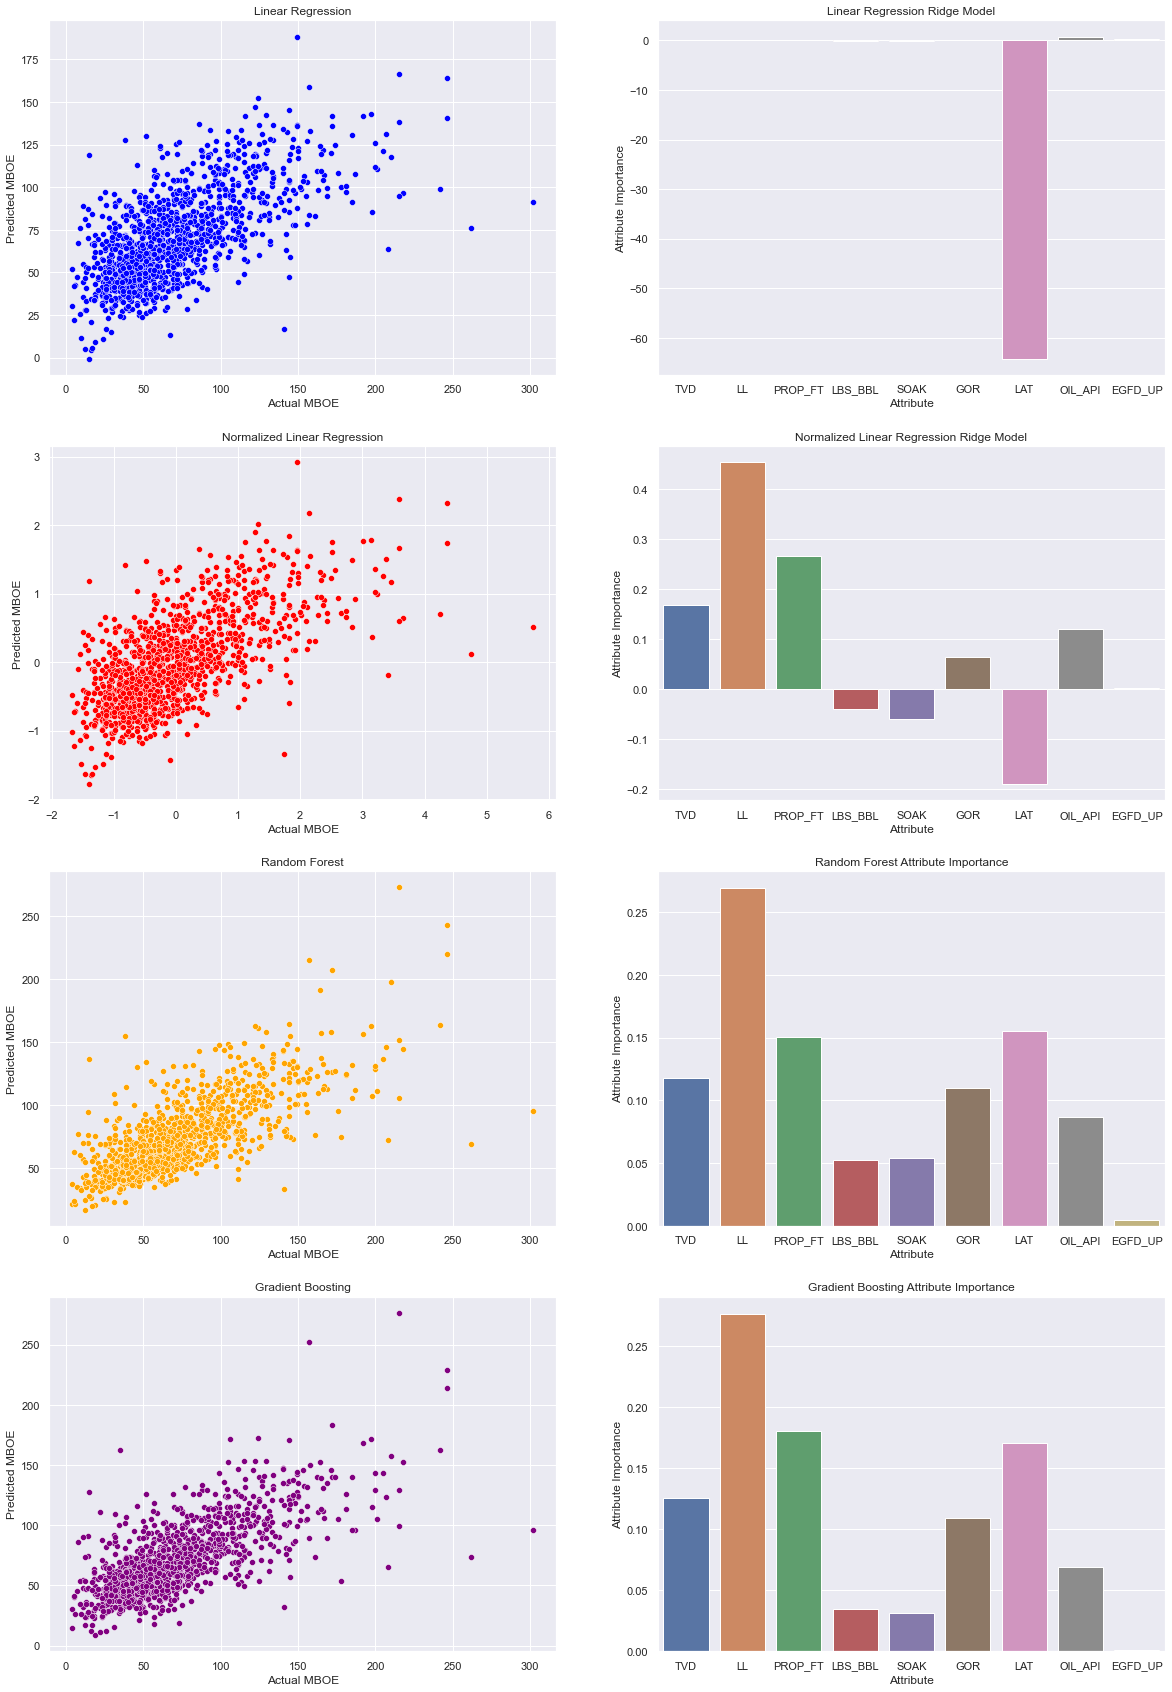

In [19]:
fig, axes = plt.subplots(4,2, figsize=(20,30))
sns.set(font_scale = 1)

sns.scatterplot(ax=axes[0,0], x = y_test, y = lm_predictions, color = 'blue')
axes[0,0].set_xlabel("Actual MBOE")
axes[0,0].set_ylabel("Predicted MBOE")
axes[0,0].set_title('Linear Regression')

sns.barplot(ax=axes[0,1], x = X.columns, y = lm_importance)
axes[0,1].set_xlabel("Attribute")
axes[0,1].set_ylabel("Attribute Importance")
axes[0,1].set_title('Linear Regression Ridge Model')

sns.scatterplot(ax=axes[1,0], x = y_n_test, y = lm_n_predictions, color = 'red')
axes[1,0].set_xlabel("Actual MBOE")
axes[1,0].set_ylabel("Predicted MBOE")
axes[1,0].set_title('Normalized Linear Regression')

sns.barplot(ax=axes[1,1], x = X_n.columns, y = lm_n_importance)
axes[1,1].set_xlabel("Attribute")
axes[1,1].set_ylabel("Attribute Importance")
axes[1,1].set_title('Normalized Linear Regression Ridge Model')

sns.scatterplot(ax = axes[2,0], x = y_test, y = rf_predictions, color = 'orange')
axes[2,0].set_xlabel("Actual MBOE")
axes[2,0].set_ylabel("Predicted MBOE")
axes[2,0].set_title('Random Forest')

sns.barplot(ax=axes[2,1], x = X.columns, y = rf_importance)
axes[2,1].set_xlabel("Attribute")
axes[2,1].set_ylabel("Attribute Importance")
axes[2,1].set_title('Random Forest Attribute Importance')

sns.scatterplot(ax = axes[3,0], x = y_test, y = gb_predictions, color = 'purple')
axes[3,0].set_xlabel("Actual MBOE")
axes[3,0].set_ylabel("Predicted MBOE")
axes[3,0].set_title('Gradient Boosting')

sns.barplot(ax=axes[3,1], x = X.columns, y = gb_importance)
axes[3,1].set_xlabel("Attribute")
axes[3,1].set_ylabel("Attribute Importance")
axes[3,1].set_title('Gradient Boosting Attribute Importance')

> According to the results, wellbore max TVD, lateral length (LL), proppant loading, GOR, and latitude (likely representing something geologic) are the biggest influencers.  It would be worth the time to recreate the models after dropping some of the less-impactful features like wellbore targeting, frac soak time (SOAK), and frac proppant/fluid ratio to see if a better fit can be achieved

### Although the normalized linear regression model sheds some light on how each feature impacts target results, let's dig a little deeper using Shapley Values from the Random Forest model.  

### First, import the shap module and specify which regressor model to use (Tree Explainer with our Random Forest model) and tie it to your training dataset.  Then generate a dataframe of the results.  It can take a while for the computer to run through a large dataset so go grab a coffee after you hit Run!

In [20]:
import shap
rf_shap = shap.TreeExplainer(rf).shap_values(X_train)
rf_shapdf = pd.DataFrame(rf_shap, columns =X_train.columns)

### Now that the Shapley Values have been generated, let's use some of the built-in shap plots

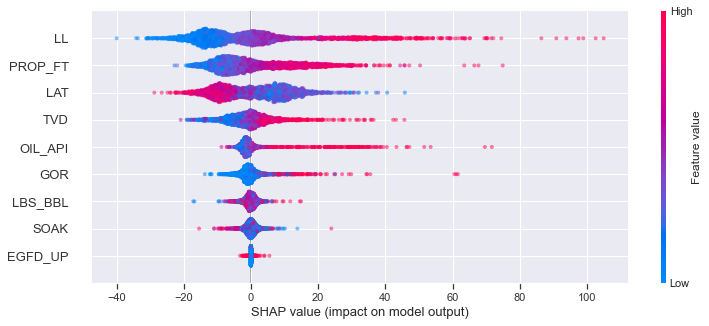

Text(0, 0.5, 'SHAP Impact on Target Variable (MBOE)')

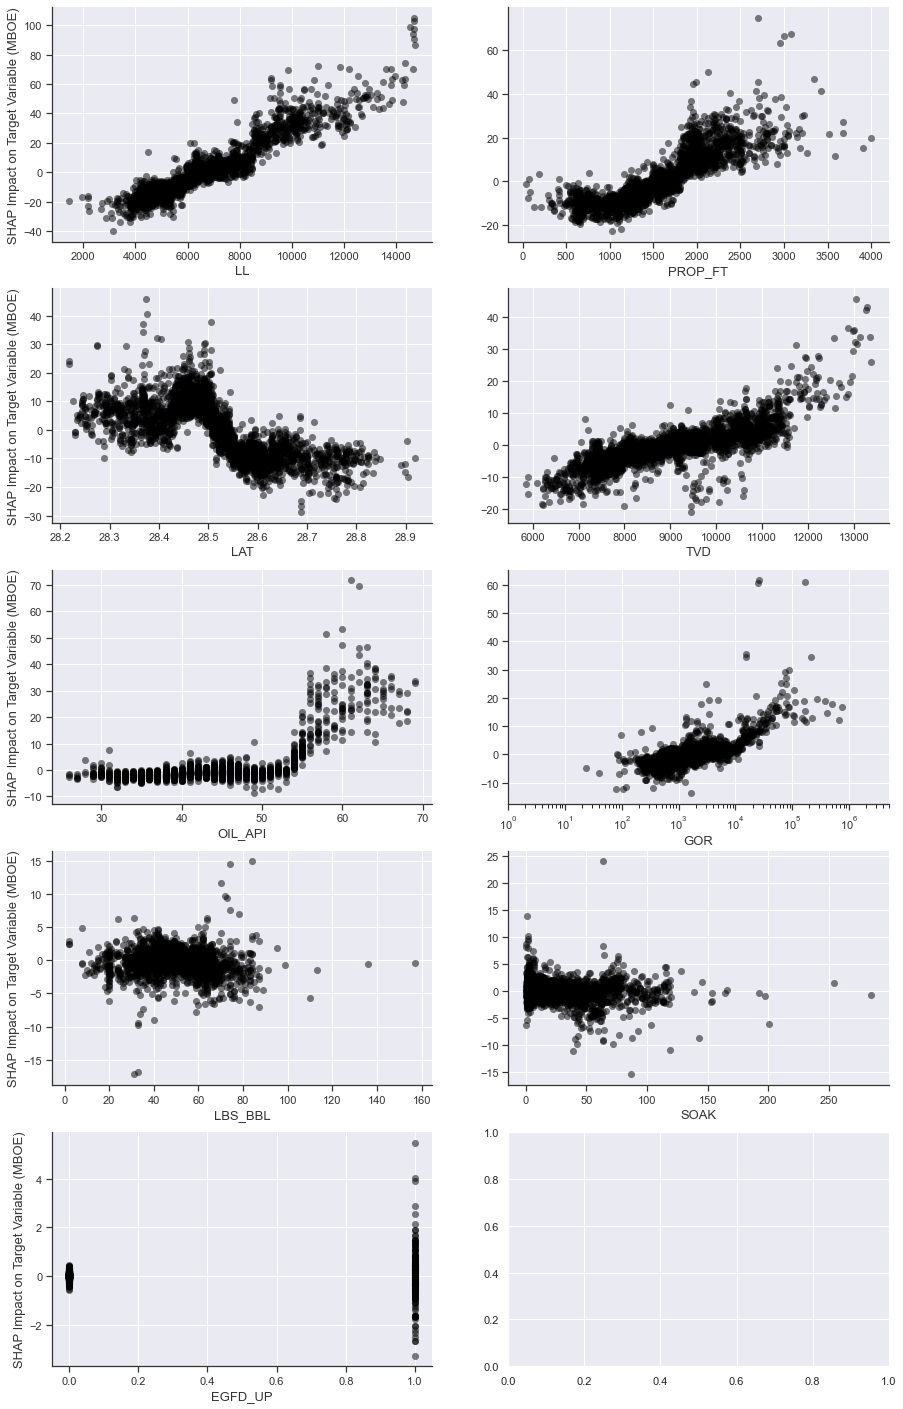

In [35]:
shap.summary_plot(rf_shap, X_train, plot_size=(12,5), alpha = 0.5)

fig, axes = plt.subplots (5,2, figsize=(15,25))

shap.dependence_plot('LL',rf_shap, X_train, interaction_index=None, ax=axes[0,0], show=False, dot_size=50, color = 'black', alpha=.5)
axes[0,0].set_ylabel("SHAP Impact on Target Variable (MBOE)")
shap.dependence_plot('PROP_FT',rf_shap, X_train, interaction_index=None, ax=axes[0,1], show=False, dot_size=50, color = 'black', alpha=.5)
axes[0,1].set_ylabel("")
shap.dependence_plot('LAT',rf_shap, X_train, interaction_index=None, ax=axes[1,0], show=False, dot_size=50, color = 'black', alpha=.5)
axes[1,0].set_ylabel("SHAP Impact on Target Variable (MBOE)")
shap.dependence_plot('TVD',rf_shap, X_train, interaction_index=None, ax=axes[1,1], show=False, dot_size=50, color = 'black', alpha=.5)
axes[1,1].set_ylabel("")
shap.dependence_plot('OIL_API',rf_shap, X_train, interaction_index=None, ax=axes[2,0], show=False, dot_size=50, color = 'black', alpha=.5)
axes[2,0].set_ylabel("SHAP Impact on Target Variable (MBOE)")
shap.dependence_plot('GOR',rf_shap, X_train, interaction_index=None, ax=axes[2,1], show=False, dot_size=50, color = 'black', alpha=.5, xmin=1, xmax=5000000)
axes[2,1].set_ylabel("")
axes[2,1].set_xscale('log')
shap.dependence_plot('LBS_BBL',rf_shap, X_train, interaction_index=None, ax=axes[3,0], show=False, dot_size=50, color = 'black', alpha=.5)
axes[3,0].set_ylabel("SHAP Impact on Target Variable (MBOE)")
shap.dependence_plot('SOAK',rf_shap, X_train, interaction_index=None, ax=axes[3,1], show=False, dot_size=50, color = 'black', alpha=.5)
axes[3,1].set_ylabel("")
shap.dependence_plot('EGFD_UP',rf_shap, X_train, interaction_index=None, ax=axes[4,0], show=False, dot_size=50, color = 'black', alpha=.5)
axes[4,0].set_ylabel("SHAP Impact on Target Variable (MBOE)")

> The results from the shapley value plots provide quite a bit of useful information.  First, it does appear that there are several feature attributes (like EGFD_UP, SOAK, LBS_BBL) that have no relationship with the target variable and should be removed from the next model iteration.  Second, we can now see how both magnitude and direction of feature influence on MBOE.  For example, TVD has a positive influence on MBOE.  We can also get a feel for feature value cutoffs for better than average target performance.  According to this model, better than average 6 month cumulative production can be achieved if you pump more than 2,000 lbs_ft, have a lateral length of >8,000', have a SHL with a latitude <28.5, have a wellbore max TVD > 9,500', have a produced oil API > 55 deg, and a GOR > 5,000 scf/bbl